In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model import run_exp
from model import default_params as params
import utils as utl
from brian2 import Hz

In [139]:
# Connections dataset and additional data sets

# Load the connections dataset
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type
connections = pd.read_csv('connections_783.csv.gz')

# Neuropil synapses
# columns: root_id, input synapses, input partners, output synapses, output partners, etc
# Keep only root_id, input syanapses, output synapses
neuropil_synapse = pd.read_csv('neuropil_synapse_table_783.csv.gz')[['root_id','input synapses','output synapses']]

# Rename with underscores
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)

# Load classification table
# columns: root_id, flow, super_class, side, etc
# Keep only root_id and side
classif = pd.read_csv('classification_783.csv.gz')[['root_id','side']]
classification = pd.read_csv('classification_783.csv.gz')

# Load data about each neuron
# columns: root_id, group, nt_type, etc
# Keep only root_id, nt_type
neurons = pd.read_csv('neurons_783.csv.gz')[['root_id','nt_type']]

# Merging additional data in one data set
neurons_data = pd.merge(neurons, pd.merge(classif, neuropil_synapse, on='root_id',how= 'outer'), on='root_id',how='outer')

hygro_df = classification[(classification['class'] == 'hygrosensory') & (classification['side'] == 'left')]
thermo_df = classification[(classification['class'] == 'thermosensory') & (classification['side'] == 'left')]
thermo_df

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
1710,720575940622972820,afferent,sensory,thermosensory,NaN,NaN,TRN_VP3b,NaN,left,AN
4942,720575940625293514,afferent,sensory,thermosensory,NaN,NaN,TRN_VP3a,NaN,left,AN
10438,720575940613794114,afferent,sensory,thermosensory,NaN,NaN,TRN_VP1m,NaN,left,AN
14064,720575940627944464,afferent,sensory,thermosensory,NaN,NaN,TRN_VP1m,NaN,left,AN
22417,720575940619024774,afferent,sensory,thermosensory,NaN,NaN,TRN_VP1m,NaN,left,AN
31183,720575940623793741,afferent,sensory,thermosensory,NaN,NaN,TRN_VP1m,NaN,left,AN
40585,720575940616039197,afferent,sensory,thermosensory,NaN,NaN,TRN_VP1m,NaN,left,AN
49230,720575940613191591,afferent,sensory,thermosensory,NaN,NaN,TRN_VP3a,NaN,left,AN
57711,720575940615856345,afferent,sensory,thermosensory,NaN,NaN,TRN_VP2,NaN,left,AN
101393,720575940646372228,afferent,sensory,thermosensory,NaN,NaN,TRN_VP2,NaN,left,AN


In [140]:
connections

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [141]:
# Define function to get downstream neuronal connections, partners, and unique partners
def neuronal_outputs(neurons, syn_filter):        
        connectivity = pd.merge(neurons['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= " + str(syn_filter))
        connectivity = connectivity.drop(columns = 'root_id')

        # Merging with classification based on post_root_id    
        downstream_neurons = pd.merge(connectivity, 
                                classification, 
                                left_on='post_root_id', 
                                right_on='root_id', 
                                how='inner')
        
        # Find unique downstream neurons that are not in the original neurons['root_id']
        unique_downstream_neurons = downstream_neurons.loc[~downstream_neurons['post_root_id'].isin(neurons['root_id'])].copy()

        return connectivity, downstream_neurons, unique_downstream_neurons

thermo_2N_connections, thermo_2Ns, thermo_unique_2Ns = neuronal_outputs(thermo_df, 5)
hygro_2N_connections, hygro_2Ns, hygro_unique_2Ns = neuronal_outputs(hygro_df, 5)

rates= [25,50,75,100,125,150,175,200] # these are the different GRN stimulation rates for the simulations

for i in rates:
    ids_activated = pd.read_csv('./results/Sep_test/CSVs/resultshygro_'+str(i)+'Hz_rates.csv')['flyid'].values
    hygro_unique_2Ns['activation_'+str(i)+'Hz'] = hygro_unique_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    hygro_unique_2Ns['label'] = 'hygro'
    hygro_2Ns['activation_'+str(i)+'Hz'] = hygro_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    hygro_2Ns['label'] = 'hygro'
    
for i in rates:
    ids_activated = pd.read_csv('./results/Sep_test/CSVs/resultsthermo_'+str(i)+'Hz_rates.csv')['flyid'].values
    thermo_unique_2Ns['activation_'+str(i)+'Hz'] = thermo_unique_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    thermo_unique_2Ns['label'] = 'thermo'
    thermo_2Ns['activation_'+str(i)+'Hz'] = thermo_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    thermo_2Ns['label'] = 'thermo'

# Display df
thermo_unique_2Ns

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,root_id,flow,super_class,class,sub_class,...,nerve,activation_25Hz,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz
0,720575940622972820,720575940613203119,AL_L,41,ACH,720575940613203119,intrinsic,central,ALPN,multiglomerular,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
1,720575940622972820,720575940625007949,AL_L,115,ACH,720575940625007949,intrinsic,central,ALPN,multiglomerular,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
2,720575940616999069,720575940625007949,AL_L,5,ACH,720575940625007949,intrinsic,central,ALPN,multiglomerular,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
3,720575940622972820,720575940621607093,AL_L,13,ACH,720575940621607093,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
4,720575940615856345,720575940621607093,AL_L,7,ACH,720575940621607093,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,720575940646372228,720575940620689524,AL_L,7,ACH,720575940620689524,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
418,720575940646372228,720575940634809455,AL_L,5,ACH,720575940634809455,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
419,720575940616999069,720575940639892413,AL_L,6,ACH,720575940639892413,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated
422,720575940618512624,720575940616642790,AL_L,5,ACH,720575940616642790,intrinsic,central,ALLN,NaN,...,NaN,activated,thermo,activated,activated,activated,activated,activated,activated,activated


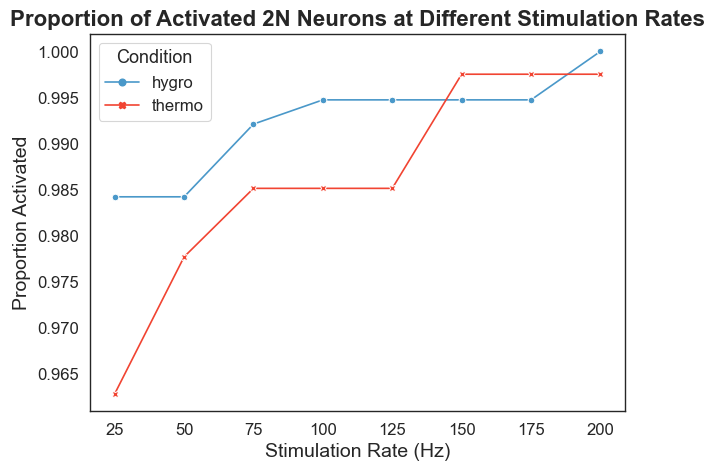

In [142]:
input_intensity = [25, 50, 75, 100, 125, 150, 175, 200]


def get_activation_columns(df):
    return [col for col in df.columns if 'activation' in col]

# Function to calculate the proportion of activated neurons for each frequency
def calculate_proportions(df, frequency):
    total_neurons = df.shape[0]
    activated_neurons = df[df[frequency] == 'activated'].shape[0]
    return activated_neurons / total_neurons

# Initialize a dictionary to store proportions for each condition
proportions = {}

# Process the hygrosensory DataFrame
activation_columns_hygro = get_activation_columns(hygro_unique_2Ns)
proportions['hygro'] = {freq: calculate_proportions(hygro_unique_2Ns, freq) for freq in activation_columns_hygro}

# Process the thermosensory DataFrame
activation_columns_thermo = get_activation_columns(thermo_unique_2Ns)
proportions['thermo'] = {freq: calculate_proportions(thermo_unique_2Ns, freq) for freq in activation_columns_thermo}

# Convert the proportions dictionary to a DataFrame for easier plotting
proportions_df = pd.DataFrame(proportions)

#palette = sns.color_palette("mako_r", 2)
sns.set_context('paper')

# Define custom color palette: blue for hygro, red for thermo
custom_palette = {'hygro': sns.color_palette("Blues", 4)[2],  # Light blue
                  'thermo': sns.color_palette("Reds", 4)[2]} 
sns.lineplot(data=proportions_df, palette=custom_palette, markers=True, dashes=False)

# Add plot titles and labels
plt.title('Proportion of Activated 2N Neurons at Different Stimulation Rates', fontsize=16, fontweight='bold')
plt.xlabel('Stimulation Rate (Hz)', fontsize=14)
plt.ylabel('Proportion Activated', fontsize=14)

# Set x-ticks to input_intensity for proper labeling
plt.xticks(proportions_df.index, labels=input_intensity, fontsize=12)

# Customize ticks on the y-axis for better readability
plt.yticks(fontsize=12)

# Add a legend with a title
plt.legend(title='Condition', fontsize=12, title_fontsize='13')

# Display the plot with tight layout
plt.tight_layout()


In [143]:
# Get 3N connections
t2N_ids = pd.DataFrame(thermo_unique_2Ns['root_id'].copy())
h2N_ids = pd.DataFrame(hygro_unique_2Ns['root_id'].copy())
thermo_3N_connections, thermo_3Ns, thermo_unique_3Ns = neuronal_outputs(t2N_ids, 10)
hygro_3N_connections, hygro_3Ns, hygro_unique_3Ns = neuronal_outputs(h2N_ids, 10)

for i in rates:
    ids_activated = pd.read_csv('./results/Sep_test/CSVs/resultshygro_'+str(i)+'Hz_rates.csv')['flyid'].values
    hygro_unique_3Ns['activation_'+str(i)+'Hz'] = hygro_unique_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    hygro_unique_3Ns['label'] = 'hygro'
    hygro_3Ns['activation_'+str(i)+'Hz'] = hygro_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    hygro_3Ns['label'] = 'hygro'
    
for i in rates:
    ids_activated = pd.read_csv('./results/Sep_test/CSVs/resultsthermo_'+str(i)+'Hz_rates.csv')['flyid'].values
    thermo_unique_3Ns['activation_'+str(i)+'Hz'] = thermo_unique_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    thermo_unique_3Ns['label'] = 'thermo'
    thermo_3Ns['activation_'+str(i)+'Hz'] = thermo_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    thermo_3Ns['label'] = 'thermo'

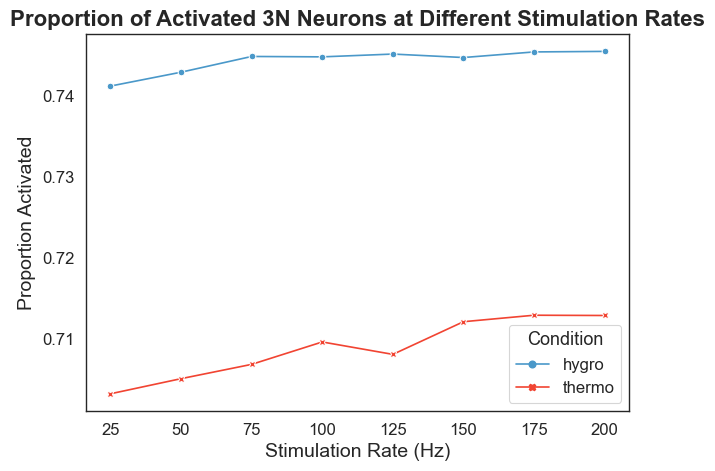

In [144]:
# Initialize a dictionary to store proportions for each condition
proportions = {}

# Process the hygrosensory DataFrame
activation_columns_hygro = get_activation_columns(hygro_unique_3Ns)
proportions['hygro'] = {freq: calculate_proportions(hygro_unique_3Ns, freq) for freq in activation_columns_hygro}

# Process the thermosensory DataFrame
activation_columns_thermo = get_activation_columns(thermo_unique_3Ns)
proportions['thermo'] = {freq: calculate_proportions(thermo_unique_3Ns, freq) for freq in activation_columns_thermo}

# Convert the proportions dictionary to a DataFrame for easier plotting
proportions_df = pd.DataFrame(proportions)

#palette = sns.color_palette("mako_r", 2)
sns.set_context('paper')

# Define custom color palette: blue for hygro, red for thermo
custom_palette = {'hygro': sns.color_palette("Blues", 4)[2],  # Light blue
                  'thermo': sns.color_palette("Reds", 4)[2]} 
sns.lineplot(data=proportions_df, palette=custom_palette, markers=True, dashes=False)

# Add plot titles and labels
plt.title('Proportion of Activated 3N Neurons at Different Stimulation Rates', fontsize=16, fontweight='bold')
plt.xlabel('Stimulation Rate (Hz)', fontsize=14)
plt.ylabel('Proportion Activated', fontsize=14)

# Set x-ticks to input_intensity for proper labeling
plt.xticks(proportions_df.index, labels=input_intensity, fontsize=12)

# Customize ticks on the y-axis for better readability
plt.yticks(fontsize=12)

# Add a legend with a title
plt.legend(title='Condition', fontsize=12, title_fontsize='13')

# Display the plot with tight layout
plt.tight_layout()

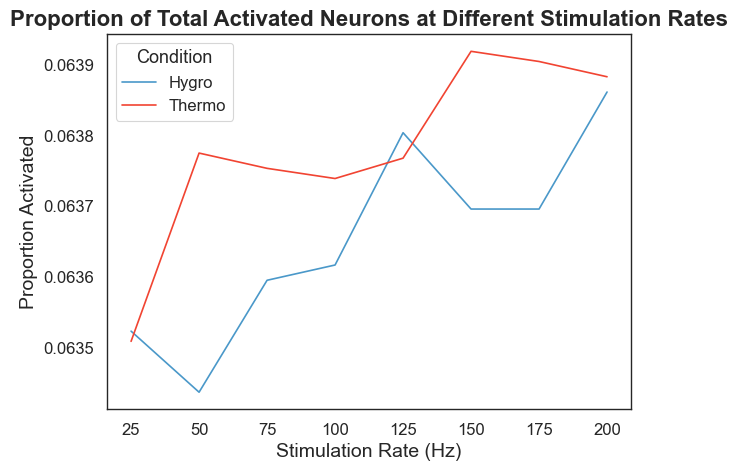

In [152]:
# Initialize lists to store activations
hygro_total_activation = []
thermo_total_activation = []

# Loop over the input intensity and calculate activations
for i in input_intensity:
    hygro_total_activation.append(pd.read_csv('./results/Sep_test/CSVs/resultshygro_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])
    thermo_total_activation.append(pd.read_csv('./results/Sep_test/CSVs/resultsthermo_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])

# Prepare data for plotting
y_total_modality = [hygro_total_activation, thermo_total_activation]

# Prepare the data in a long-format DataFrame for Seaborn
data = {
    'Stim Intensity (Hz)': input_intensity * 2,  # Repeat input_intensity for both modalities
    'Proportion': hygro_total_activation + thermo_total_activation,  # Concatenate both lists
    'Modality': ['Hygro'] * len(input_intensity) + ['Thermo'] * len(input_intensity)  # Label each modality
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Set Seaborn context
sns.set_context('paper')

# Disable grid lines
plt.grid(False)

# Define custom color palette: blue for hygro, red for thermo
custom_palette = {'Hygro': sns.color_palette("Blues", 4)[2],  # Light blue
                  'Thermo': sns.color_palette("Reds", 4)[2]} 

sns.lineplot(data=df, x='Stim Intensity (Hz)', y='Proportion', hue='Modality', palette=custom_palette, markers=True, dashes=False)

# Add plot titles and labels
plt.title('Proportion of Total Activated Neurons at Different Stimulation Rates', fontsize=16, fontweight='bold')
plt.xlabel('Stimulation Rate (Hz)', fontsize=14)
plt.ylabel('Proportion Activated', fontsize=14)

# Add ticks on the outside
plt.tick_params(axis='both', direction='out', length=6, width=2)

# Set x-ticks to input_intensity for proper labeling
plt.xticks(fontsize=12)

# Customize ticks on the y-axis for better readability
plt.yticks(fontsize=12)

# Add a legend with a title
plt.legend(title='Condition', fontsize=12, title_fontsize='13')

# Show the plot
plt.tight_layout()

In [161]:
# 
t2N_class_proportions = thermo_unique_2Ns['class'].value_counts(normalize=True)
t2N_superclass_proportions = thermo_unique_2Ns['super_class'].value_counts(normalize=True)
t2N_nt_proportions = thermo_unique_2Ns['nt_type'].value_counts(normalize=True)

# 
t3N_class_proportions = thermo_unique_3Ns['class'].value_counts(normalize=True)
t3N_superclass_proportions = thermo_unique_3Ns['super_class'].value_counts(normalize=True)
t3N_nt_proportions = thermo_unique_3Ns['nt_type'].value_counts(normalize=True)

t3N_superclass_proportions
sensory3Ns = thermo_unique_3Ns[thermo_unique_3Ns['super_class'] == 'sensory']
sensory3N_proportions = sensory3Ns['class'].value_counts(normalize=True)
sensory3N_proportions

olfactory        0.787324
hygrosensory     0.132248
thermosensory    0.080428
Name: class, dtype: float64